This notebook does XXX

In [15]:
# for importing and reading the zipfile shapefile
import requests
import zipfile
import io
import os

# for maps
import geopandas as gpd
import folium

# for processing the large parque files via Apache Spark
from IPython.display import display
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from scipy import stats

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("maps")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/10 21:23:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# URL where the zipfile of the shapefiles are stored on the ABS website
zip_file_url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/POA_2021_AUST_GDA94_SHP.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# output directory, making sure it exists
dir = "../../../data/postcode_shapefiles"
os.makedirs(dir)

# writing data into directory
z.extractall(dir)

In [4]:
sf = gpd.read_file("../../../data/postcode_shapefiles/POA_2021_AUST_GDA94.shp")

cols_to_remove = ['POA_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'LOCI_URI21', 'SHAPE_Leng', 'SHAPE_Area']
sf = sf.drop(columns=cols_to_remove)

sf.head()

,POA_CODE21,AREASQKM21,geometry
0,0800,3.1731,"POLYGON ((130.83680 -12.45378, 130.83683 -12.4..."
1,0810,24.4283,"POLYGON ((130.89985 -12.36568, 130.89874 -12.3..."
2,0812,35.8899,"POLYGON ((130.91914 -12.40788, 130.91830 -12.4..."
3,0820,39.0642,"POLYGON ((130.85260 -12.43995, 130.85088 -12.4..."
4,0822,150775.8030,"MULTIPOLYGON (((136.56647 -12.08393, 136.56703..."


In [5]:
geoJSON = sf[['POA_CODE21', 'geometry']].drop_duplicates('POA_CODE21').to_json()

In [6]:
path = "../../../data/curated/all_data_combined.parquet"
data = spark.read.parquet(path)

cols_to_remove = ['merchant_abn','order_datetime', 'user_id', 'consumer_id', 'consumer_name', 'consumer_gender', 'merchant_name', 'merchant_description', 'merchant_revenue_level']

data = data.drop(*cols_to_remove)
data.show()

+-----------------+--------------+-----------------------------+----------------------------+--------------------+----------------------------+--------------------------------------+----------------------------+-----------------------------------------------+-----------------------------------------------+------------------------------------+-------------------------------------------+------------------------------------------+-------------------------------------------+------------------------------------+
|consumer_postcode|consumer_state|transaction_dollar_value_$AUD|consumer_fraud_probability_%|merchant_take_rate_%|merchant_fraud_probability_%|consumer_postcode_estimated_population|consumer_postcode_median_age|consumer_postcode_median_mortgage_repay_monthly|consumer_postcode_median_totl_prsnal_inc_weekly|consumer_postcode_median_rent_weekly|consumer_postcode_median_tot_fam_inc_weekly|consumer_postcode_avg_num_psns_per_bedroom|consumer_postcode_median_tot_hhd_inc_weekly|consumer_pos

In [7]:
map_data = data[['consumer_postcode', 'transaction_dollar_value_$AUD', 'consumer_postcode_median_totl_prsnal_inc_weekly', 'consumer_postcode_estimated_population']] \
				  .groupby('consumer_postcode') \
				  .agg(
					  {
						  'transaction_dollar_value_$AUD': 'avg', # average transaction size
						  'consumer_postcode_median_totl_prsnal_inc_weekly': 'min', # gets median from each postcode
						  'consumer_postcode': 'count', # numnber of transactions per postcode
						  'consumer_postcode_estimated_population': 'min' # est pop per postcode

					  }
				  )

# renaming the coloumns
map_data  = map_data .withColumnRenamed('avg(transaction_dollar_value_$AUD)', 'mean_transaction_dollar_value')
map_data  = map_data .withColumnRenamed('min(consumer_postcode_median_totl_prsnal_inc_weekly)', 'median_weekly_income')
map_data  = map_data .withColumnRenamed('count(consumer_postcode)', 'num_transactions')
map_data  = map_data .withColumnRenamed('min(consumer_postcode_estimated_population)', 'postcode_population')

map_data .limit(10)

consumer_postcode,median_weekly_income,postcode_population,mean_transaction_dollar_value,num_transactions
6721,1821.0,5384.0,145.96947182059586,3389
3091,950.0,9521.0,158.8689708050722,3391
2040,1459.5,15750.0,154.56176748303332,3389
3764,837.0,10330.0,161.68478065899777,5129
2250,772.5,9290.0,163.44781158572258,5127
2214,797.0,11375.0,167.46177025963812,5084
3061,437.0,16245.0,157.15832671957668,4536
3280,760.0,22470.0,149.8647826941985,5085
2173,1027.0,21301.0,153.2518363717207,4498
6424,853.0,3090.0,162.03576648841366,4488


In [24]:
map_data  = map_data .withColumn(
    'proportion_of_transaction_to_income',
    col('mean_transaction_dollar_value') / col('median_weekly_income')
)

map_data  = map_data .withColumn(
    'transactions_per_person',
    col('num_transactions') / col('postcode_population')
)

map_data_pd = map_data .toPandas()
print(map_data_pd.shape)
map_data_pd.head()

(2639, 7)


,consumer_postcode,median_weekly_income,postcode_population,mean_transaction_dollar_value,num_transactions,proportion_of_transaction_to_income,transactions_per_person
0,6721,1821.0,5384.0,145.969472,3389,0.080159,0.629458
1,3091,950.0,9521.0,158.868971,3391,0.167230,0.356160
2,2040,1459.5,15750.0,154.561767,3389,0.105900,0.215175
3,3764,837.0,10330.0,161.684781,5129,0.193172,0.496515
4,2250,772.5,9290.0,163.447812,5127,0.211583,0.551884


In [25]:
max_value = map_data_pd['transactions_per_person'].max()

min_value = map_data_pd['transactions_per_person'].min()

median_value = map_data_pd['transactions_per_person'].median()

mean_value = map_data_pd['transactions_per_person'].mean()

# Print the results
print(f"Maximum: {max_value}")
print(f"Minimum: {min_value}")
print(f"Median: {median_value}")
print(f"Mean: {mean_value}")

Maximum: 1135.6666666666667
Minimum: 0.02889841137123746
Median: 0.48414830736163356
Mean: 1.5604066032808772


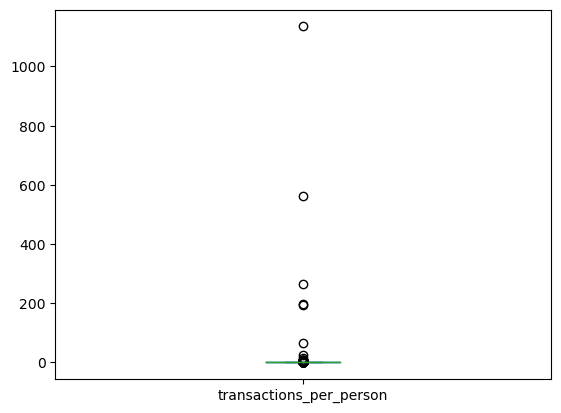

In [37]:
import matplotlib.pyplot as plt
map_data_pd['transactions_per_person'].plot(kind='box')
plt.show()

In [39]:
Q1 = map_data_pd['transactions_per_person'].quantile(0.25)
Q3 = map_data_pd['transactions_per_person'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
map_data_pd_no_outliers = map_data_pd[(map_data_pd['transactions_per_person'] >= lower_bound) & (map_data_pd['transactions_per_person'] <= upper_bound)]

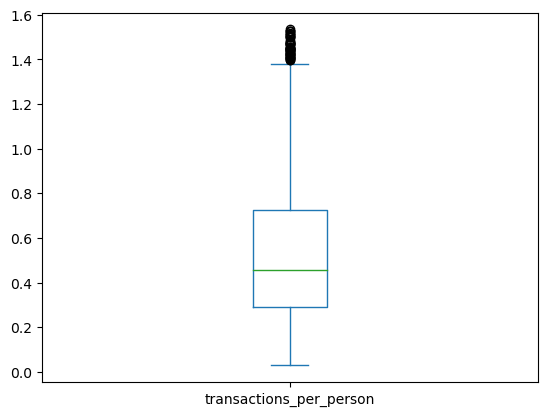

In [40]:
map_data_pd_no_outliers['transactions_per_person'].plot(kind='box')
plt.show()

In [ ]:
map = folium.Map(location=[-27.7744, 133.7751], tiles="OpenStreetMap", zoom_start=4)

test = folium.Choropleth(
	geo_data=geoJSON,
	name = 'choropleth',
	data = map_data_pd_no_outliers,
	columns = ["consumer_postcode", "transactions_per_person"],
	key_on = 'properties.POA_CODE21',
	fill_color = 'YlOrRd',
	nan_fill_color = 'black',
	legend_name = "Number of Transactions per person"
)

test.add_to(map)

# display(map)